In [ ]:
 !mkdir -p /data/sets/nuscenes  # Make the directory to store the nuScenes dataset in.

 !wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

 !tar -xf v1.0-mini.tgz -C /data/sets/nuscenes  # Uncompress the nuScenes mini split.

 !pip install nuscenes-devkit &> /dev/null  # Install nuScenes.

--2022-07-11 05:30:22--  https://www.nuscenes.org/data/v1.0-mini.tgz
Resolving www.nuscenes.org (www.nuscenes.org)... 54.192.18.63, 54.192.18.36, 54.192.18.64, ...
Connecting to www.nuscenes.org (www.nuscenes.org)|54.192.18.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4167696325 (3.9G) [application/x-tar]
Saving to: ‘v1.0-mini.tgz’

v1.0-mini.tgz       100%[===================>]   3.88G  17.5MB/s    in 4m 9s   

2022-07-11 05:34:33 (16.0 MB/s) - ‘v1.0-mini.tgz’ saved [4167696325/4167696325]



NameError: ignored

In [ ]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.064 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


In [ ]:
import argparse
import json
import os
from collections import OrderedDict
from typing import List, Tuple, Union

import numpy as np
from pyquaternion.quaternion import Quaternion
from shapely.geometry import MultiPoint, box
from tqdm import tqdm

from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import view_points

In [ ]:
def post_process_coords(corner_coords: List,
                        imsize: Tuple[int, int] = (1600, 900)) -> Union[Tuple[float, float, float, float], None]:
    """
    Get the intersection of the convex hull of the reprojected bbox corners and the image canvas, return None if no
    intersection.
    :param corner_coords: Corner coordinates of reprojected bounding box.
    :param imsize: Size of the image canvas.
    :return: Intersection of the convex hull of the 2D box corners and the image canvas.
    """
    polygon_from_2d_box = MultiPoint(corner_coords).convex_hull
    img_canvas = box(0, 0, imsize[0], imsize[1])

    if polygon_from_2d_box.intersects(img_canvas):
        img_intersection = polygon_from_2d_box.intersection(img_canvas)
        intersection_coords = np.array([coord for coord in img_intersection.exterior.coords])

        min_x = min(intersection_coords[:, 0])
        min_y = min(intersection_coords[:, 1])
        max_x = max(intersection_coords[:, 0])
        max_y = max(intersection_coords[:, 1])

        return min_x, min_y, max_x, max_y
    else:
        return None

In [ ]:
def generate_record(ann_rec: dict,
                    x1: float,
                    y1: float,
                    x2: float,
                    y2: float,
                    sample_data_token: str,
                    filename: str) -> OrderedDict:
    """
    Generate one 2D annotation record given various informations on top of the 2D bounding box coordinates.
    :param ann_rec: Original 3d annotation record.
    :param x1: Minimum value of the x coordinate.
    :param y1: Minimum value of the y coordinate.
    :param x2: Maximum value of the x coordinate.
    :param y2: Maximum value of the y coordinate.
    :param sample_data_token: Sample data token.
    :param filename:The corresponding image file where the annotation is present.
    :return: A sample 2D annotation record.
    """
    repro_rec = OrderedDict()
    repro_rec['sample_data_token'] = sample_data_token

    relevant_keys = [
        'attribute_tokens',
        'category_name',
        'instance_token',
        'next',
        'num_lidar_pts',
        'num_radar_pts',
        'prev',
        'sample_annotation_token',
        'sample_data_token',
        'visibility_token',
    ]

    for key, value in ann_rec.items():
        if key in relevant_keys:
            repro_rec[key] = value

    repro_rec['bbox_corners'] = [x1, y1, x2, y2]
    repro_rec['filename'] = filename

    return repro_rec

In [ ]:
def get_2d_boxes(sample_data_token: str, visibilities: List[str]) -> List[OrderedDict]:
    """
    Get the 2D annotation records for a given `sample_data_token`.
    :param sample_data_token: Sample data token belonging to a camera keyframe.
    :param visibilities: Visibility filter.
    :return: List of 2D annotation record that belongs to the input `sample_data_token`
    """

    # Get the sample data and the sample corresponding to that sample data.
    sd_rec = nusc.get('sample_data', sample_data_token)

    assert sd_rec['sensor_modality'] == 'camera', 'Error: get_2d_boxes only works for camera sample_data!'
    if not sd_rec['is_key_frame']:
        raise ValueError('The 2D re-projections are available only for keyframes.')

    s_rec = nusc.get('sample', sd_rec['sample_token'])

    # Get the calibrated sensor and ego pose record to get the transformation matrices.
    cs_rec = nusc.get('calibrated_sensor', sd_rec['calibrated_sensor_token'])
    pose_rec = nusc.get('ego_pose', sd_rec['ego_pose_token'])
    camera_intrinsic = np.array(cs_rec['camera_intrinsic'])

    # Get all the annotation with the specified visibilties.
    ann_recs = [nusc.get('sample_annotation', token) for token in s_rec['anns']]
    ann_recs = [ann_rec for ann_rec in ann_recs if (ann_rec['visibility_token'] in visibilities)]

    repro_recs = []

    for ann_rec in ann_recs:
        # Augment sample_annotation with token information.
        ann_rec['sample_annotation_token'] = ann_rec['token']
        ann_rec['sample_data_token'] = sample_data_token

        # Get the box in global coordinates.
        box = nusc.get_box(ann_rec['token'])

        # Move them to the ego-pose frame.
        box.translate(-np.array(pose_rec['translation']))
        box.rotate(Quaternion(pose_rec['rotation']).inverse)

        # Move them to the calibrated sensor frame.
        box.translate(-np.array(cs_rec['translation']))
        box.rotate(Quaternion(cs_rec['rotation']).inverse)

        # Filter out the corners that are not in front of the calibrated sensor.
        corners_3d = box.corners()
        in_front = np.argwhere(corners_3d[2, :] > 0).flatten()
        corners_3d = corners_3d[:, in_front]

        # Project 3d box to 2d.
        corner_coords = view_points(corners_3d, camera_intrinsic, True).T[:, :2].tolist()

        # Keep only corners that fall within the image.
        final_coords = post_process_coords(corner_coords)

        # Skip if the convex hull of the re-projected corners does not intersect the image canvas.
        if final_coords is None:
            continue
        else:
            min_x, min_y, max_x, max_y = final_coords

        # Generate dictionary record to be included in the .json file.
        repro_rec = generate_record(ann_rec, min_x, min_y, max_x, max_y, sample_data_token, sd_rec['filename'])
        repro_recs.append(repro_rec)

    return repro_recs


In [ ]:
def main(args):
    """Generates 2D re-projections of the 3D bounding boxes present in the dataset."""

    print("Generating 2D reprojections of the nuScenes dataset")

    # Get tokens for all camera images.
    sample_data_camera_tokens = [s['token'] for s in nusc.sample_data if (s['sensor_modality'] == 'camera') and
                                 s['is_key_frame']]

    # For debugging purposes: Only produce the first n images.
    if args.image_limit != -1:
        sample_data_camera_tokens = sample_data_camera_tokens[:args.image_limit]

    # Loop through the records and apply the re-projection algorithm.
    reprojections = []
    for token in tqdm(sample_data_camera_tokens):
        reprojection_records = get_2d_boxes(token, args.visibilities)
        reprojections.extend(reprojection_records)

    # Save to a .json file.
    dest_path = os.path.join(args.dataroot, args.version)
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)
    with open(os.path.join(args.dataroot, args.version, args.filename), 'w') as fh:
        json.dump(reprojections, fh, sort_keys=True, indent=4)

    print("Saved the 2D re-projections under {}".format(os.path.join(args.dataroot, args.version, args.filename)))

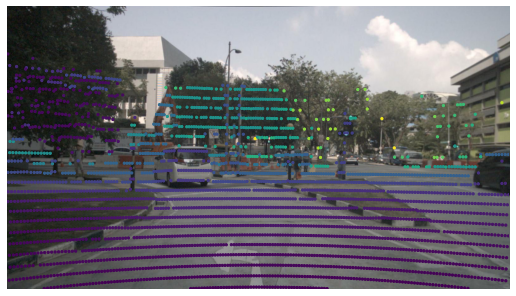

In [ ]:
my_sample = nusc.sample[10]
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP')

In [ ]:
print(dir(nusc))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__load_table__', '__lt__', '__make_reverse_index__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_token2ind', 'attribute', 'box_velocity', 'calibrated_sensor', 'category', 'colormap', 'dataroot', 'ego_pose', 'explorer', 'field2token', 'get', 'get_box', 'get_boxes', 'get_sample_data', 'get_sample_data_path', 'get_sample_lidarseg_stats', 'getind', 'instance', 'list_attributes', 'list_categories', 'list_lidarseg_categories', 'list_panoptic_instances', 'list_sample', 'list_scenes', 'load_lidarseg_cat_name_mapping', 'log', 'map', 'render_annotation', 'render_egoposes_on_map', 'render_instance', 'render_pointcloud_in_image', 'render_sample', 'render_sample_data', 'render_scene', 'render_scene_channel', '

In [ ]:
export_2d_annotations_as_json('/data/sets/nuscenes','v1.0-mini','image_2dannotations.json',['', '1', '2', '3', '4'], 5)

NameError: ignored

In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Export 2D annotations from reprojections to a .json file.',
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--dataroot', type=str, default='/data/sets/nuscenes', help="Path where nuScenes is saved.")
    parser.add_argument('--version', type=str, default='v1.0-mini', help='Dataset version.')
    parser.add_argument('--filename', type=str, default='image_2dannotations.json', help='Output filename.')
    parser.add_argument('--visibilities', type=str, default=['', '1', '2', '3', '4'],
                        help='Visibility bins, the higher the number the higher the visibility.', nargs='+')
    parser.add_argument('--image_limit', type=int, default=5, help='Number of images to process or -1 to process all.')
    args = parser.parse_args()

    nusc = NuScenes(dataroot=args.dataroot, version=args.version)
    main(args)

usage: ipykernel_launcher.py [-h] [--dataroot DATAROOT] [--version VERSION]
                             [--filename FILENAME]
                             [--visibilities VISIBILITIES [VISIBILITIES ...]]
                             [--image_limit IMAGE_LIMIT]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-70efad69-c7f7-498a-9eca-c6fd10a6f251.json


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
